<h2 style="color:green;">AI-Based Multi-Crop Price Forecasting and Hoarding Detection System for Agricultural Markets in Madhya Pradesh</h1>


In [40]:
import pandas as pd
df = pd.read_excel("garlic.xlsx")
df.head()
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10408 entries, 0 to 10407
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   State           10408 non-null  object        
 1   District        10408 non-null  object        
 2   Market          10408 non-null  object        
 3   Commodity       10408 non-null  object        
 4   Variety         10408 non-null  object        
 5   Grade           10408 non-null  object        
 6   Arrival_Date    10408 non-null  datetime64[ns]
 7   Min_Price       10408 non-null  int64         
 8   Max_Price       10408 non-null  int64         
 9   Modal_Price     10408 non-null  int64         
 10  Commodity_Code  10408 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(6)
memory usage: 894.6+ KB


State             0
District          0
Market            0
Commodity         0
Variety           0
Grade             0
Arrival_Date      0
Min_Price         0
Max_Price         0
Modal_Price       0
Commodity_Code    0
dtype: int64

<h2 style="color:green;">Feature Engineering and Linear and polynomial Model Training</h2>

In [41]:

# ---------- Simple, clean, beginner-friendly garlic pipeline ----------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# --------- 1) Load & basic clean ----------
df = pd.read_excel("garlic.xlsx")
df.columns = df.columns.str.lower().str.replace(" ", "_")
df['arrival_date'] = pd.to_datetime(df['arrival_date'], errors='coerce')

# keep needed cols only (your file columns)
df = df[['arrival_date', 'commodity', 'variety', 'min_price', 'max_price', 'modal_price']]

# drop rows without modal_price and sort
df = df.dropna(subset=['modal_price']).sort_values('arrival_date').reset_index(drop=True)

# --------- 2) Feature engineering (same as you had) ----------
df['month'] = df['arrival_date'].dt.month
df['year']  = df['arrival_date'].dt.year

# lag features (these create NaNs at the top)
df['lag_1'] = df['modal_price'].shift(1)
df['lag_2'] = df['modal_price'].shift(2)
df['lag_3'] = df['modal_price'].shift(3)

# moving averages
df['ma_3'] = df['modal_price'].rolling(3, min_periods=1).mean()
df['ma_7'] = df['modal_price'].rolling(7, min_periods=1).mean()

# drop initial rows with NaNs created by lagging so model has consistent rows
df = df.dropna(subset=['lag_1','lag_2','lag_3']).reset_index(drop=True)

# --------- 3) Prepare X,y and train-test split (time-based) ----------
feature_cols = ['month', 'year', 'lag_1', 'lag_2', 'lag_3', 'ma_7']
X_df = df[feature_cols].copy()
y = df['modal_price'].copy()

# time-based split: first 80% train, last 20% test (no shuffling)
n = len(X_df)
split_idx = int(n * 0.8)
X_train_df = X_df.iloc[:split_idx]
y_train = y.iloc[:split_idx]

# polynomial transform & model training (degree 3 as before)
poly = PolynomialFeatures(degree=3, include_bias=False)
Xp_train = poly.fit_transform(X_train_df)
model = LinearRegression()
model.fit(Xp_train, y_train)

# --------- 4) Predict for ALL eligible rows and attach to df ----------
Xp_all = poly.transform(X_df)             # transform all rows (same poly)
preds_all = model.predict(Xp_all)         # predict for all eligible rows

# map back to df
df['pred_price'] = preds_all

# --------- 5) Evaluate on the test part (optional) ----------
y_test = y.iloc[split_idx:]
pred_test = preds_all[split_idx:]
print("Test R2: {:.4f}".format(r2_score(y_test, pred_test)))
mse = mean_squared_error(y_test, pred_test)
print("Test RMSE: {:.4f}".format(np.sqrt(mse)))

# --------- 6) Simple hoarding detection (VERY simple & explainable) ----------
# price moving average for trend
df['price_ma_30'] = df['modal_price'].rolling(30, min_periods=1).mean()

# simple relative price difference (fraction)
df['price_z'] = (df['modal_price'] - df['price_ma_30']) / (df['price_ma_30'] + 1e-9)

# residual (actual - predicted)
df['residual'] = df['modal_price'] - df['pred_price']

# simple rules (tune thresholds later if you want)
# - price_z > 0.20  -> price > 20% above recent average
# - residual > 500  -> actual price > predicted by more than 500 Rs/quintal (adjust to your unit)
def simple_hoarding_flag(row, price_z_thr=0.20, residual_thr=500):
    if row['price_z'] > price_z_thr:
        return 1
    if row['residual'] > residual_thr:
        return 1
    return 0

df['hoarding_flag'] = df.apply(simple_hoarding_flag, axis=1)

# show recent rows with flags
print("\nRecent rows (with simple hoarding flag):")
display_cols = ['arrival_date','modal_price','pred_price','price_z','residual','hoarding_flag']
print(df[display_cols].tail(12))

# --------- 7) Predict next-month price (simple step using last row) ----------
latest = df.iloc[-1]
future_month = (latest['month'] % 12) + 1
future_year  = latest['year'] + (1 if latest['month'] == 12 else 0)

# build the input features for the next-month prediction (use latest available numbers)
new_row = {
    'month': future_month,
    'year' : future_year,
    'lag_1': latest['modal_price'],
    'lag_2': latest['lag_1'],
    'lag_3': latest['lag_2'],
    'ma_7' : df['modal_price'].tail(7).mean()
}
new_X = pd.DataFrame([new_row])
new_Xp = poly.transform(new_X)
future_price = model.predict(new_Xp)[0]
print("\nPredicted next-month modal price (approx.): {:.2f}".format(future_price))

# --------- 8) Very simple SELL / STORE recommendation ----------
# example storage cost (adjust with real local number; unit assumed same as modal_price)
storage_cost_30d = 200.0   # rupees per quintal for 30 days (example)
desired_margin = 0.10      # 10% desired margin

current_price = latest['modal_price']
expected_profit = future_price - current_price - storage_cost_30d
expected_margin = expected_profit / (current_price + 1e-9)

if df['hoarding_flag'].iloc[-1] == 1:
    recommendation = "SELL_NOW (high hoarding signal)"
elif expected_profit > 0 and expected_margin >= desired_margin:
    recommendation = f"STORE (~Rs {expected_profit:.0f}/quintal expected in 30 days)"
else:
    recommendation = "SELL_NOW (low expected profit)"

print("Recommendation (based on latest data):", recommendation)

# --------- 9) Save results (optional) ----------
df.to_csv("garlic_with_preds_and_flags.csv", index=False)
print("\nSaved cleaned results to garlic_with_preds_and_flags.csv")


Test R2: 0.8915
Test RMSE: 2519.9535

Recent rows (with simple hoarding flag):
      arrival_date  modal_price   pred_price   price_z     residual  \
10393   2025-10-31         1500  2956.248988 -0.612406 -1456.248988   
10394   2025-10-31         3100  2812.331306 -0.140409   287.668694   
10395   2025-10-31         2500  1975.499376 -0.309970   524.500624   
10396   2025-10-31         2500  2273.352401 -0.306775   226.647599   
10397   2025-10-31         4000  2540.382779  0.109160  1459.617221   
10398   2025-11-01         4000  2686.139239  0.086268  1313.860761   
10399   2025-11-01         1600  2052.498888 -0.559306  -452.498888   
10400   2025-11-01         1000  2451.652218 -0.710866 -1451.652218   
10401   2025-11-01         2400  2872.060980 -0.290899  -472.060980   
10402   2025-11-01         4000  3550.731996  0.312393   449.268004   
10403   2025-11-01         4000  3337.009728  0.372605   662.990272   
10404   2025-11-01         2030  2033.339134 -0.287010    -3.339134  

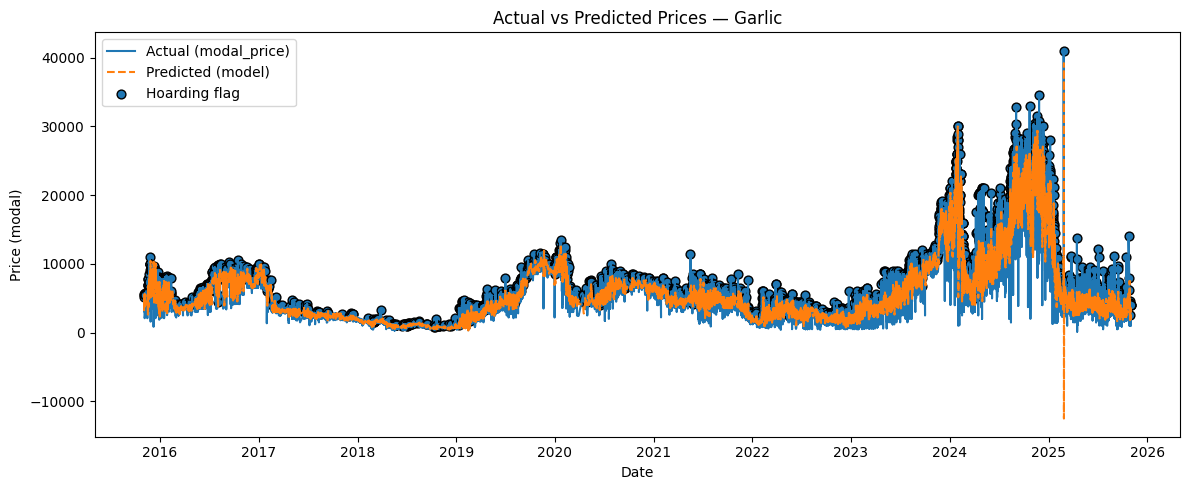

In [42]:
#section 3
import matplotlib.pyplot as plt

# ensure df is sorted by date
df = df.sort_values('arrival_date').reset_index(drop=True)

plt.figure(figsize=(12,5))
plt.plot(df['arrival_date'], df['modal_price'], label='Actual (modal_price)')
plt.plot(df['arrival_date'], df['pred_price'], label='Predicted (model)', linestyle='--')
# highlight hoarding days (where hoarding_flag == 1)
if 'hoarding_flag' in df.columns:
    hoard = df[df['hoarding_flag'] == 1]
    if not hoard.empty:
        plt.scatter(hoard['arrival_date'], hoard['modal_price'], s=40, marker='o', label='Hoarding flag', edgecolors='black')
plt.xlabel('Date')
plt.ylabel('Price (modal)')
plt.title('Actual vs Predicted Prices — Garlic')
plt.legend()
plt.tight_layout()
plt.show()


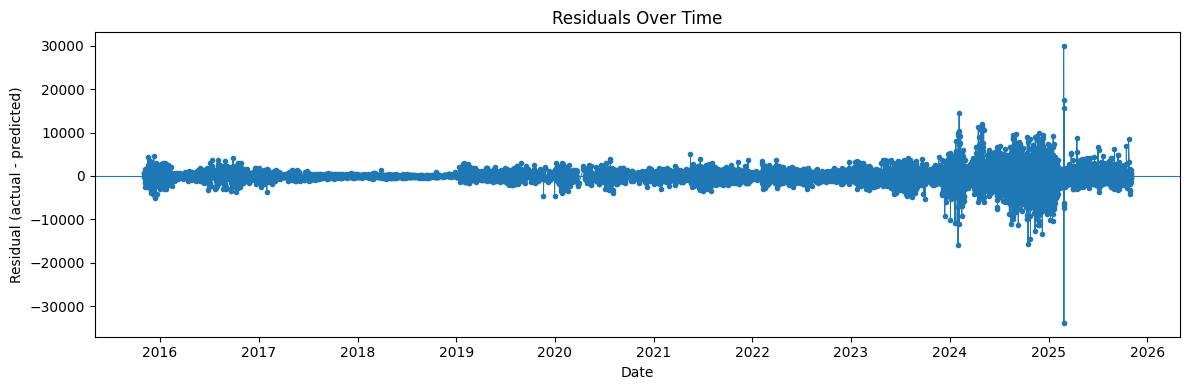

In [43]:
plt.figure(figsize=(12,4))
plt.plot(df['arrival_date'], df['residual'], marker='.', linewidth=0.7)
plt.axhline(0, linewidth=0.8)  # zero error line
plt.xlabel('Date')
plt.ylabel('Residual (actual - predicted)')
plt.title('Residuals Over Time')
plt.tight_layout()
plt.show()


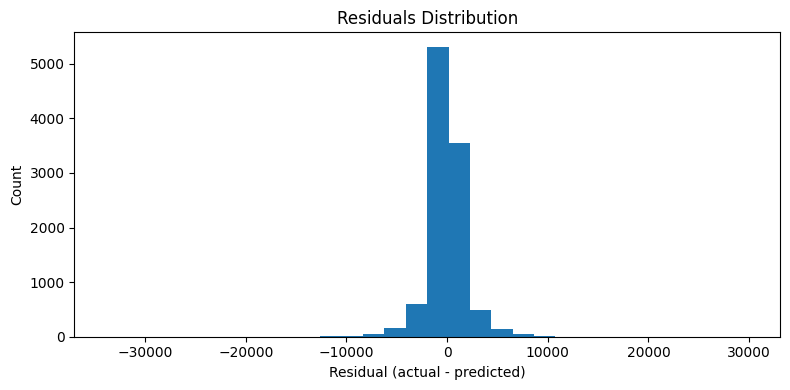

In [44]:
plt.figure(figsize=(8,4))
plt.hist(df['residual'].dropna(), bins=30)
plt.xlabel('Residual (actual - predicted)')
plt.ylabel('Count')
plt.title('Residuals Distribution')
plt.tight_layout()
plt.show()


<h2 style="color:green;">Multi-model training, evaluation and best-model selection with hoarding detection</h1>

In [45]:
import numpy as np
import pandas as pd

# ML imports
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
import joblib
import warnings
warnings.filterwarnings("ignore")

# Optional XGBoost
USE_XGBOOST = True
try:
    if USE_XGBOOST:
        from xgboost import XGBRegressor
except Exception:
    USE_XGBOOST = False
    print("xgboost not available — skipping XGBRegressor. To enable, install with: pip install xgboost")

# ---------- Prepare features & time-based split (same as your previous code) ----------
feature_cols = ['month', 'year', 'lag_1', 'lag_2', 'lag_3', 'ma_7']
X_df = df[feature_cols].copy()
y = df['modal_price'].copy().values

n = len(df)
split_idx = int(n * 0.8)   # first 80% train, last 20% test (time series split)

X_train_df = X_df.iloc[:split_idx].values
X_test_df  = X_df.iloc[split_idx:].values
y_train = y[:split_idx]
y_test  = y[split_idx:]

print(f"Rows -> total: {n}, train: {len(X_train_df)}, test: {len(X_test_df)}")

# ---------- Define model candidates ----------
models = {}

# 1) Polynomial Linear Regression (degree=3) as pipeline
poly = PolynomialFeatures(degree=3, include_bias=False)
models['PolyLR'] = Pipeline([
    ('poly', poly),
    ('lr', LinearRegression())
])

# 2) Plain Linear Regression (no poly)
models['Linear'] = LinearRegression()

# 3) Random Forest
models['RandomForest'] = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)

# 4) Gradient Boosting
models['GradientBoosting'] = GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, random_state=42)

# 5) KNN
models['KNN'] = KNeighborsRegressor(n_neighbors=5)

# 6) SVR (pipeline with scaler)
models['SVR'] = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='rbf', C=10, epsilon=0.1))
])

# 7) XGBoost (optional)
if USE_XGBOOST:
    models['XGBoost'] = XGBRegressor(n_estimators=200, learning_rate=0.05, n_jobs=-1, random_state=42, verbosity=0)

# ---------- Train & evaluate each model ----------
results = []
for name, mdl in models.items():
    # Fit on training set
    mdl.fit(X_train_df, y_train)
    # Predict on test set
    ypred = mdl.predict(X_test_df)
    r2 = r2_score(y_test, ypred)
    rmse = np.sqrt(mean_squared_error(y_test, ypred))
    results.append({'model': name, 'estimator': mdl, 'r2': r2, 'rmse': rmse})
    print(f"{name:15s} | R2 = {r2:.4f} | RMSE = {rmse:.2f}")

# ---------- Select best model ----------
res_df = pd.DataFrame(results).sort_values(by=['r2','rmse'], ascending=[False, True]).reset_index(drop=True)
print("\nModel ranking (sorted by R2 desc, RMSE asc):")
print(res_df[['model','r2','rmse']])

best_row = res_df.iloc[0]
best_name = best_row['model']
best_model = best_row['estimator']
print(f"\nBEST MODEL -> {best_name}  (R2={best_row['r2']:.4f}, RMSE={best_row['rmse']:.2f})")

# ---------- Attach best-model predictions to full df ----------
# We must transform the full feature matrix consistent with how best_model expects inputs.
# For pipelines (Polynomial or scaler), calling best_model.predict on raw X_df.values is fine.
X_all = X_df.values
df['pred_best'] = best_model.predict(X_all)
df['residual_best'] = df['modal_price'] - df['pred_best']

# ---------- Re-run hoarding detection using best model's preds ----------
# Use same simple rules you used earlier (tweak thresholds if needed)
df['price_ma_30'] = df['modal_price'].rolling(30, min_periods=1).mean()
df['price_rel'] = (df['modal_price'] - df['price_ma_30']) / (df['price_ma_30'] + 1e-9)

price_rel_thr = 0.20     # 20% above 30-day mean
residual_thr = 500.0     # ₹500 above predicted (adjust to your unit)

df['hoarding_flag_best'] = ((df['price_rel'] > price_rel_thr) | (df['residual_best'] > residual_thr)).astype(int)
print("Total hoarding flags (best-model):", df['hoarding_flag_best'].sum())

# Show recent rows and flagged instances
display_cols = ['arrival_date','modal_price','pred_best','residual_best','price_rel','hoarding_flag_best']
print("\nRecent rows (tail):")
print(df[display_cols].tail(8))
print("\nSample flagged rows:")
print(df.loc[df['hoarding_flag_best']==1, display_cols].head(8))

# ---------- Save best model ----------
joblib.dump(best_model, "best_model_joblib.pkl")
print("Saved best model to best_model_joblib.pkl")

# ---------- Optional: predict next-month using best model ----------
latest = df.iloc[-1]
future_month = (latest['month'] % 12) + 1
future_year  = latest['year'] + (1 if latest['month']==12 else 0)

new_row = pd.DataFrame([{
    'month': future_month,
    'year': future_year,
    'lag_1': latest['modal_price'],
    'lag_2': latest['lag_1'],
    'lag_3': latest['lag_2'],
    'ma_7': df['modal_price'].tail(7).mean()
}])

# prediction using best_model (works for pipelines and plain estimators)
future_price = best_model.predict(new_row[feature_cols].values)[0]
print(f"Predicted next-month modal price by BEST model ({best_name}): {future_price:.2f}")

# ---------- Save results to CSV ----------
df.to_csv("garlic_with_best_model_preds_flags.csv", index=False)
print("Saved results to garlic_with_best_model_preds_flags.csv")


Rows -> total: 10405, train: 8324, test: 2081
PolyLR          | R2 = 0.8915 | RMSE = 2521.28
Linear          | R2 = 0.9088 | RMSE = 2311.69
RandomForest    | R2 = 0.8974 | RMSE = 2451.71
GradientBoosting | R2 = 0.9000 | RMSE = 2420.53
KNN             | R2 = 0.8854 | RMSE = 2591.52
SVR             | R2 = 0.4528 | RMSE = 5661.86
XGBoost         | R2 = 0.8937 | RMSE = 2495.75

Model ranking (sorted by R2 desc, RMSE asc):
              model        r2         rmse
0            Linear  0.908773  2311.690803
1  GradientBoosting  0.899980  2420.528257
2      RandomForest  0.897387  2451.705018
3           XGBoost  0.893667  2495.753293
4            PolyLR  0.891481  2521.281661
5               KNN  0.885350  2591.516480
6               SVR  0.452754  5661.857029

BEST MODEL -> Linear  (R2=0.9088, RMSE=2311.69)
Total hoarding flags (best-model): 3386

Recent rows (tail):
      arrival_date  modal_price    pred_best  residual_best  price_rel  \
10397   2025-10-31         4000  2546.427906    14

<h2 style="color:green;">Grouped bar chart: model R2 across dataset sizes (100%, 50%, 25%)</h1>

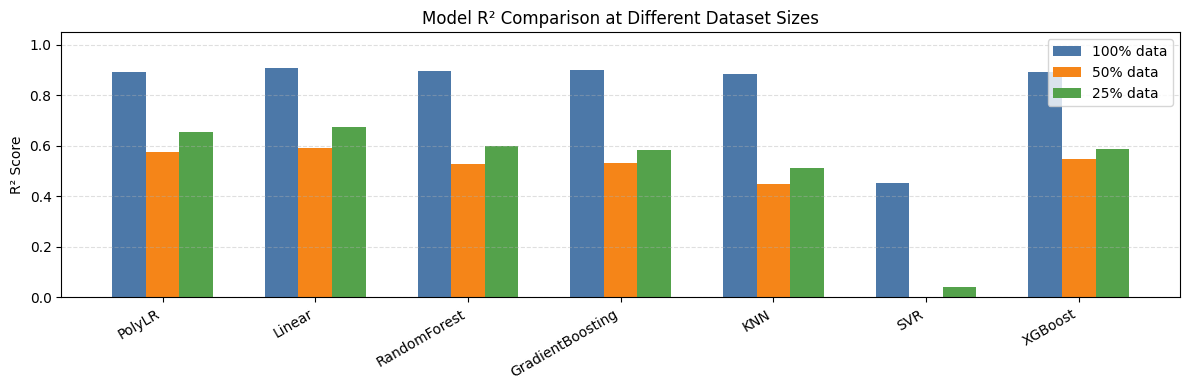

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error

# Try to import XGBoost if available
USE_XGB = False
try:
    from xgboost import XGBRegressor
    USE_XGB = True
except Exception:
    # xgboost not available; will skip
    pass

# Models dictionary (pipelines where needed)
models = {
    "PolyLR": Pipeline([('poly', PolynomialFeatures(degree=3, include_bias=False)),
                        ('lr', LinearRegression())]),
    "Linear": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, random_state=42),
    "KNN": KNeighborsRegressor(n_neighbors=5),
    "SVR": Pipeline([('scaler', StandardScaler()), ('svr', SVR(kernel='rbf', C=10, epsilon=0.1))])
}
if USE_XGB:
    models["XGBoost"] = XGBRegressor(n_estimators=200, learning_rate=0.05, random_state=42, verbosity=0)

# Feature columns (same as your pipeline)
feature_cols = ['month', 'year', 'lag_1', 'lag_2', 'lag_3', 'ma_7']

# Function to evaluate models on a truncated dataset (time-ordered)
def evaluate_on_fraction(df, fraction):
    n_total = len(df)
    n_use = int(np.floor(n_total * fraction))
    if n_use < 50:
        raise ValueError("Too few rows for training; choose a larger fraction.")
    d = df.iloc[:n_use].copy()   # earliest records — keep time order
    X = d[feature_cols].values
    y = d['modal_price'].values
    # train/test time split: train first 80% of this truncated data, test last 20%
    split = int(len(d) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]
    scores = {}
    for name, mdl in models.items():
        try:
            mdl.fit(X_train, y_train)
            ypred = mdl.predict(X_test)
            r2 = r2_score(y_test, ypred)
            rmse = np.sqrt(mean_squared_error(y_test, ypred))
            scores[name] = {"r2": r2, "rmse": rmse}
        except Exception as e:
            scores[name] = {"r2": np.nan, "rmse": np.nan}
            print(f"Model {name} failed on fraction {fraction}: {e}")
    return scores

# Evaluate for the three sizes
fractions = [1.0, 0.5, 0.25]   # 100%, 50%, 25%
all_results = {frac: evaluate_on_fraction(df, frac) for frac in fractions}

# Build DataFrame for plotting (R2)
models_list = list(models.keys())
r2_matrix = np.array([[all_results[frac][m]['r2'] if m in all_results[frac] else np.nan
                       for m in models_list] for frac in fractions])

# Plot grouped bar chart
labels = models_list
x = np.arange(len(labels))
width = 0.22

plt.figure(figsize=(12,4))
colors = ['#4C78A8','#F58518','#54A24B']  # three nice colors for 100/50/25
for i, frac in enumerate(fractions):
    plt.bar(x + (i-1)*width, r2_matrix[i], width=width, label=f"{int(frac*100)}% data", color=colors[i])

plt.xticks(x, labels, rotation=30, ha='right')
plt.ylim(0, 1.05)
plt.ylabel("R² Score")
plt.title("Model R² Comparison at Different Dataset Sizes")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


<h2 style="color:green;">Visulaizations</h2>

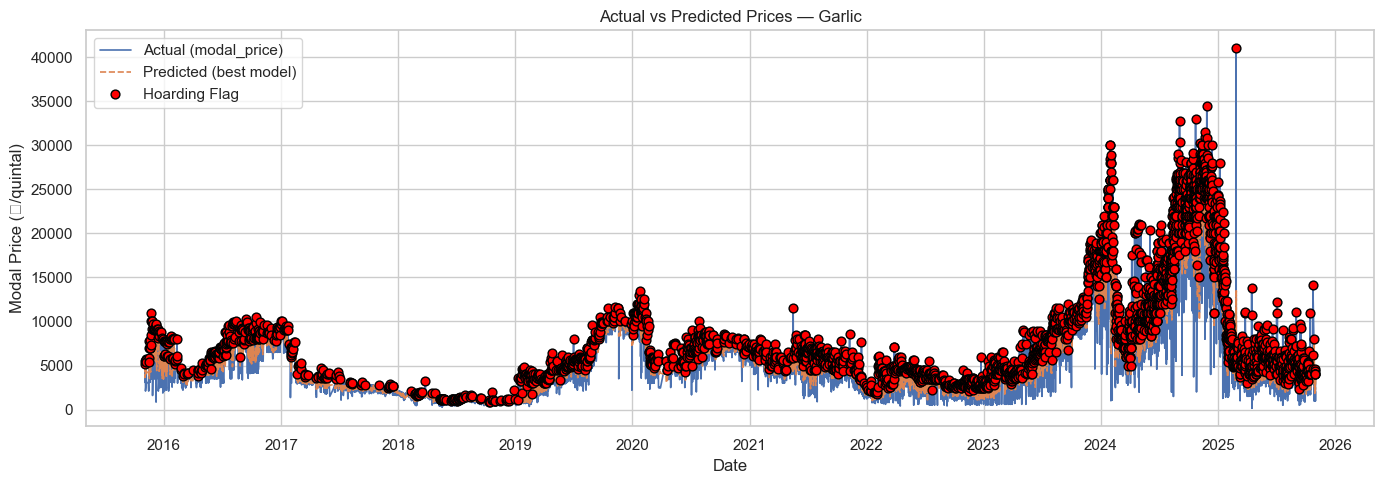

In [46]:
# VIS-1: Actual vs Predicted time-series with hoarding flags
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(14,5))
plt.plot(df['arrival_date'], df['modal_price'], label='Actual (modal_price)', linewidth=1.2)
if 'pred_best' in df.columns:
    plt.plot(df['arrival_date'], df['pred_best'], label='Predicted (best model)', linestyle='--', linewidth=1.2)
else:
    plt.plot(df['arrival_date'], df['pred_price'], label='Predicted (poly model)', linestyle='--', linewidth=1.2)

# highlight hoarding days (where hoarding_flag_best or hoarding_flag == 1)
flag_col = 'hoarding_flag_best' if 'hoarding_flag_best' in df.columns else ('hoarding_flag' if 'hoarding_flag' in df.columns else None)
if flag_col:
    hoard = df[df[flag_col] == 1]
    if not hoard.empty:
        plt.scatter(hoard['arrival_date'], hoard['modal_price'], s=40, marker='o',
                    label='Hoarding Flag', edgecolors='black', color='red', zorder=4)

plt.xlabel('Date')
plt.ylabel('Modal Price (₹/quintal)')
plt.title('Actual vs Predicted Prices — Garlic')
plt.legend()
plt.tight_layout()
plt.show()


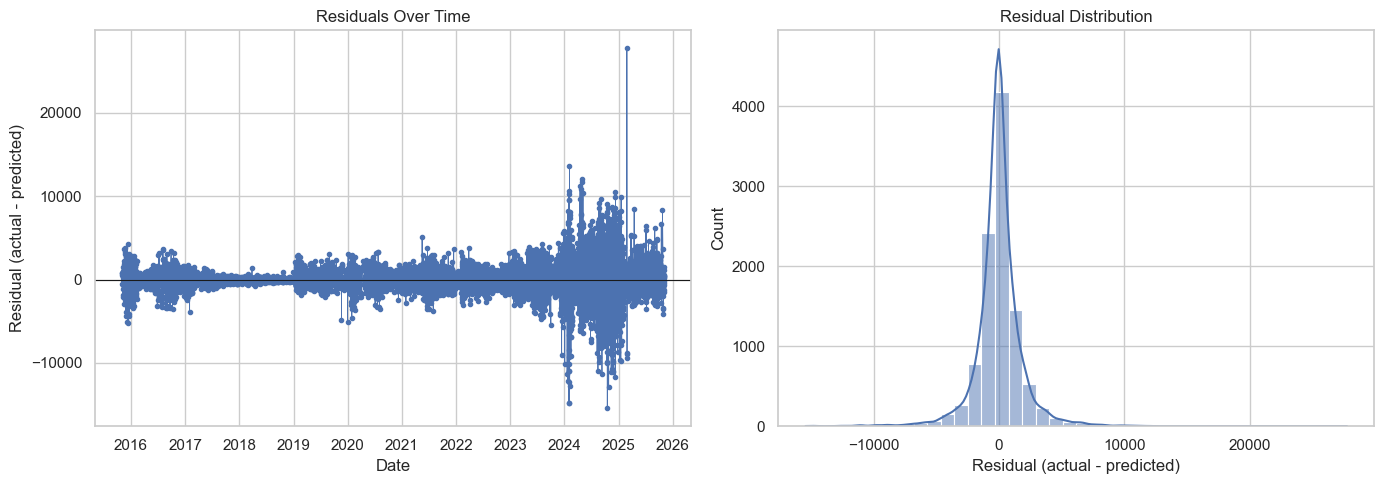

In [47]:
# VIS-2: Residuals time series and distribution
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
if 'residual_best' in df.columns:
    res_col = 'residual_best'
else:
    res_col = 'residual'
plt.plot(df['arrival_date'], df[res_col], marker='.', linewidth=0.6)
plt.axhline(0, color='k', lw=0.8)
plt.xlabel('Date'); plt.ylabel('Residual (actual - predicted)')
plt.title('Residuals Over Time')

plt.subplot(1,2,2)
sns.histplot(df[res_col].dropna(), bins=40, kde=True)
plt.xlabel('Residual (actual - predicted)'); plt.title('Residual Distribution')

plt.tight_layout()
plt.show()


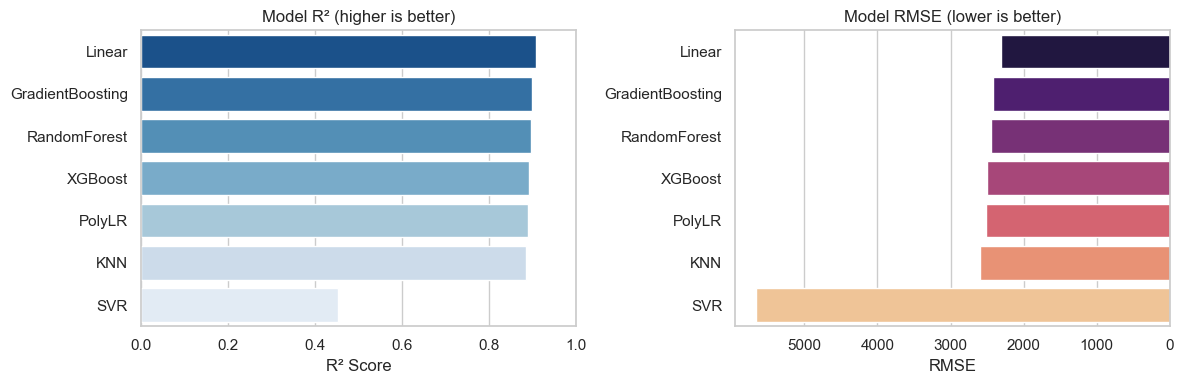

In [48]:
# VIS-3: Model comparison (R2 and RMSE)
import numpy as np
import pandas as pd

# Get results DataFrame
if 'res_df' in globals():
    df_res = res_df.copy()
else:
    df_res = pd.DataFrame(results)  # fallback if results list exists

# ensure order
df_res = df_res.sort_values('r2', ascending=False).reset_index(drop=True)
models_names = df_res['model'].tolist()
r2_vals = df_res['r2'].tolist()
rmse_vals = df_res['rmse'].tolist()

fig, axes = plt.subplots(1,2, figsize=(12,4), gridspec_kw={'width_ratios':[1,1]})
sns.barplot(x=r2_vals, y=models_names, ax=axes[0], palette="Blues_r")
axes[0].set_xlim(0,1)
axes[0].set_title('Model R² (higher is better)')
axes[0].set_xlabel('R² Score')

sns.barplot(x=rmse_vals, y=models_names, ax=axes[1], palette="magma")
axes[1].invert_xaxis()  # show better (lower) near left optionally
axes[1].set_title('Model RMSE (lower is better)')
axes[1].set_xlabel('RMSE')

plt.tight_layout()
plt.show()


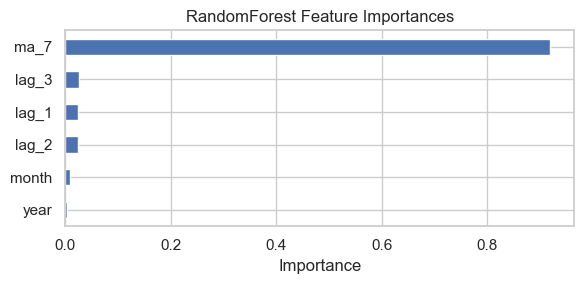

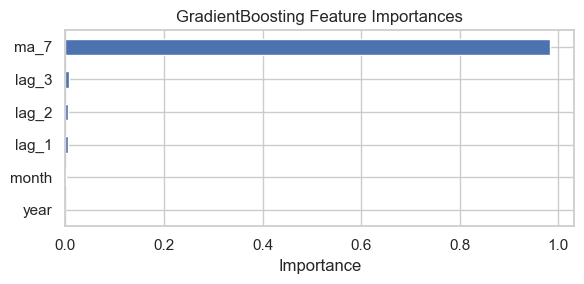

In [49]:
# VIS-4: Feature importances from tree models (RF or GradientBoosting)
import numpy as np

def plot_feature_importances(estimator, title):
    importances = None
    if hasattr(estimator, 'feature_importances_'):
        importances = estimator.feature_importances_
    elif hasattr(estimator, 'named_steps') and 'feature_importances_' in dir(estimator.named_steps.get(estimator.steps[-1][0], estimator)):
        importances = estimator.named_steps[list(estimator.named_steps.keys())[-1]].feature_importances_
    if importances is None:
        print(f"No feature_importances_ for {title}")
        return
    fi = pd.Series(importances, index=feature_cols).sort_values(ascending=True)
    fi.plot(kind='barh', figsize=(6,3), title=title)
    plt.xlabel('Importance'); plt.tight_layout()
    plt.show()

# try RandomForest first
if 'RandomForest' in models:
    try:
        rf_model = None
        # get trained estimator from results/res_df
        if 'res_df' in globals():
            row = res_df[res_df['model']=='RandomForest']
            if not row.empty:
                rf_model = row.iloc[0]['estimator']
        if rf_model is None and 'models' in globals():
            rf_model = models.get('RandomForest')
        if rf_model is not None:
            plot_feature_importances(rf_model, "RandomForest Feature Importances")
    except Exception as e:
        print("RF plot failed:", e)

# then GradientBoosting
if 'GradientBoosting' in models:
    try:
        gb_model = None
        if 'res_df' in globals():
            row = res_df[res_df['model']=='GradientBoosting']
            if not row.empty:
                gb_model = row.iloc[0]['estimator']
        if gb_model is None:
            gb_model = models.get('GradientBoosting')
        if gb_model is not None:
            plot_feature_importances(gb_model, "GradientBoosting Feature Importances")
    except Exception as e:
        print("GB plot failed:", e)


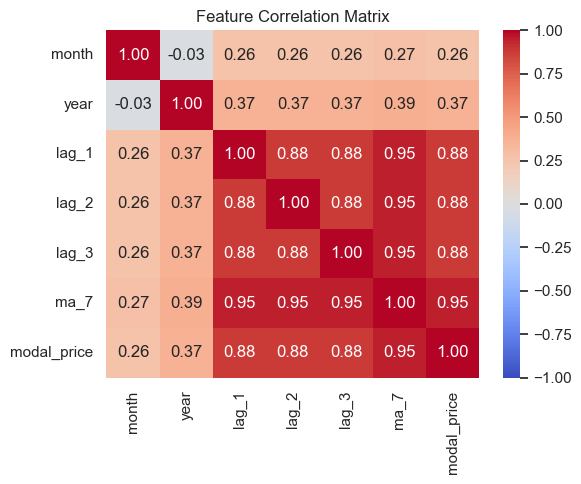

In [50]:
# VIS-5: Correlation matrix heatmap for features and modal_price
corr_cols = feature_cols + ['modal_price']
corr = df[corr_cols].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()


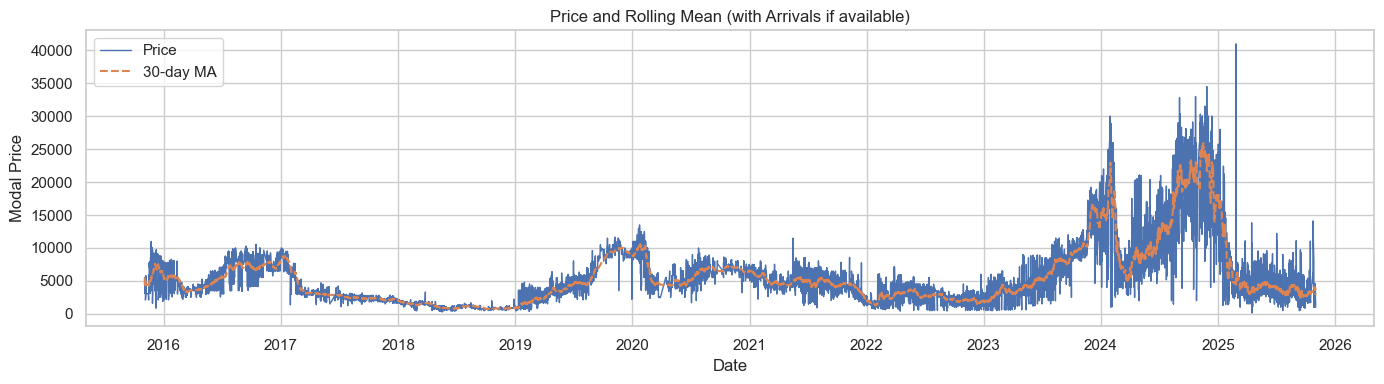

In [51]:
# VIS-6: Price with rolling mean and arrivals (if arrivals exists)
plt.figure(figsize=(14,4))
plt.plot(df['arrival_date'], df['modal_price'], label='Price', linewidth=1)
plt.plot(df['arrival_date'], df['price_ma_30'], label='30-day MA', linewidth=1.5, linestyle='--')
if 'arrivals' in df.columns:
    ax = plt.gca()
    ax2 = ax.twinx()
    ax2.bar(df['arrival_date'], df['arrivals'], alpha=0.15, label='Arrivals (tonnes)')
    ax2.set_ylabel('Arrivals')
plt.title('Price and Rolling Mean (with Arrivals if available)')
plt.xlabel('Date'); plt.ylabel('Modal Price')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


<h2 style="color:green;">Small dashboard summary</h2>

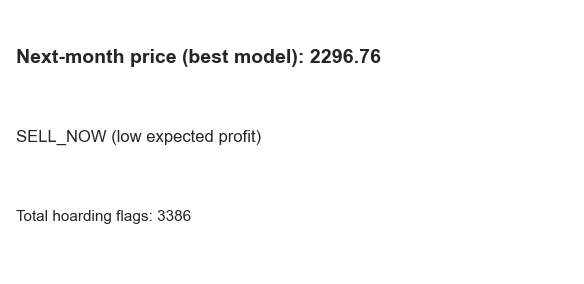

In [52]:
# VIS-7: Small dashboard summary
pred_text = f"Next-month price (best model): {future_price:.2f}" if 'future_price' in globals() else "Next-month price: N/A"
rec_text = recommendation if 'recommendation' in globals() else "Recommendation: N/A"
fig, ax = plt.subplots(figsize=(6,3))
ax.axis('off')
ax.text(0.01, 0.8, pred_text, fontsize=14, fontweight='bold')
ax.text(0.01, 0.5, rec_text, fontsize=12)
# show last flagged events count
flags = df['hoarding_flag_best'].sum() if 'hoarding_flag_best' in df.columns else (df['hoarding_flag'].sum() if 'hoarding_flag' in df.columns else 0)
ax.text(0.01, 0.2, f"Total hoarding flags: {flags}", fontsize=11)
plt.tight_layout()
plt.show()
